# CNN on CIFAR-10
**This notebook: [see on github](https://github.com/drinkingkazu/2019-06-17-NeuralNets/blob/master/CIFAR-10%20CNN.ipynb) or [run it on google colab](https://colab.research.google.com/github/drinkingkazu/2019-06-17-NeuralNets/blob/master/CIFAR-10%20CNN.ipynb)**.

This notebook trains CNN on CIFAR-10 dataset, 10 object classification in 32x32 pixels images with 3 channels. 

In [1]:
from __future__ import print_function
import matplotlib
%matplotlib inline
import torch
import numpy as np
SEED=123
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

We will use [`kworkshop.utils`](https://github.com/drinkingkazu/kworkshop/blob/master/utils) package. In case it's not available here, curl it.

In [2]:
! [ -d kworkshop ] || git clone -b 2019-06-17-NeuralNets https://github.com/drinkingkazu/kworkshop

# Prepare dataset

0it [00:00, ?it/s]

170500096it [00:03, 42836258.65it/s]                               


Files already downloaded and verified


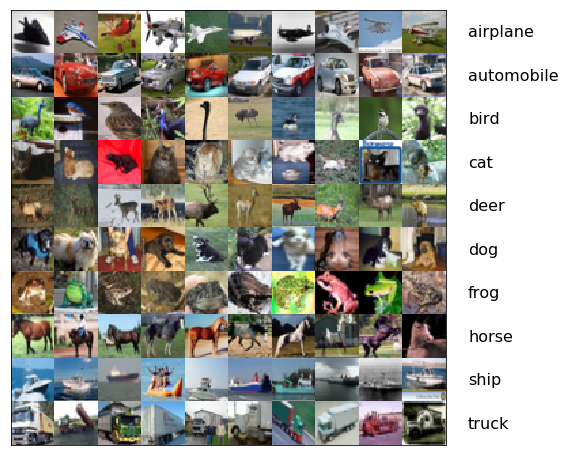

In [3]:
from torchvision import datasets, transforms
# Data file download directory
LOCAL_DATA_DIR = './data'
# Prepare train data
train_dataset = datasets.CIFAR10(LOCAL_DATA_DIR, train=True, download=True,
                                 transform=transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=1,pin_memory=True)
# Prepare test data
test_dataset = datasets.CIFAR10(LOCAL_DATA_DIR, train=False, download=True,
                                transform=transforms.Compose([transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=40,shuffle=False,num_workers=2,pin_memory=True)
# Visualize classes
from kworkshop.utils import plot_dataset
plot_dataset(train_dataset)

<a href="network"></a>
# Define a network

In [4]:
class CNN(torch.nn.Module):
    def __init__(self):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(3,32,3,padding=1), torch.nn.BatchNorm2d(32),            
            torch.nn.ReLU(),
            torch.nn.Conv2d(32,32,3,padding=1), torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            
            torch.nn.Conv2d(32,64,3,padding=1), torch.nn.BatchNorm2d(64),            
            torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3,padding=1), torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            
            torch.nn.Conv2d(64,128,3,padding=1), torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3,padding=1), torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            
            torch.nn.Conv2d(128,256,3,padding=1), torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256,256,3,padding=1), torch.nn.BatchNorm2d(256),
            torch.nn.ReLU())
        # classifier MLP
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(4*4*256,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,10) )
        
        def weights_init(m):
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_uniform_(m.weight)
                    
        self._feature_extractor.apply(weights_init)

    def forward(self, x):
        # extract features
        features = self._feature_extractor(x)
        # flatten the 3d tensor (2d space x channels = features)
        features = features.view(-1, np.prod(features.size()[1:]))
        # classify and return
        return self._classifier(features)

# Create Blob

In [5]:
class BLOB:
    pass
blob=BLOB()
blob.net       = CNN().cuda() # construct Lenet, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters(),weight_decay=0.001) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.iteration = 0    # integer count for the number of train steps
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

<a href="train"></a>
# Train

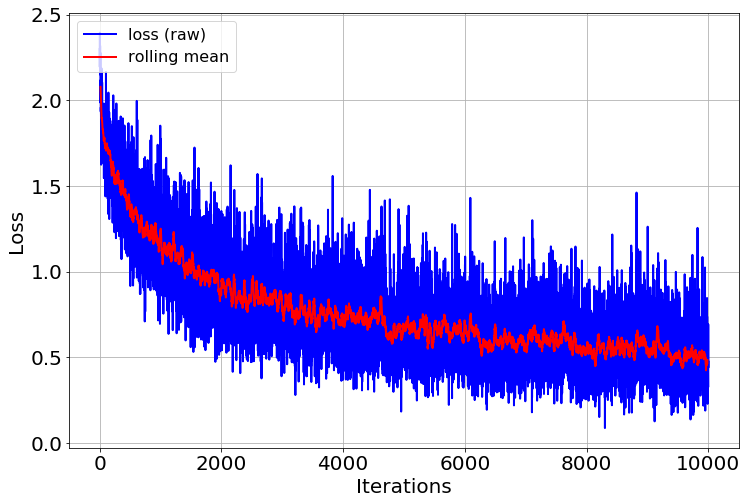

In [6]:
# Import train_loop, plot_loss
from kworkshop.utils import train_loop, plot_loss, save_state
# Train
plot_loss(train_loop(blob,train_loader,num_iteration=10000))
# Save
blob.weight_file=save_state(blob,prefix='./CIFAR10-CNN')

# Evaluation

Train set accuracy mean 0.800323896353167 std 0.07105951190535481


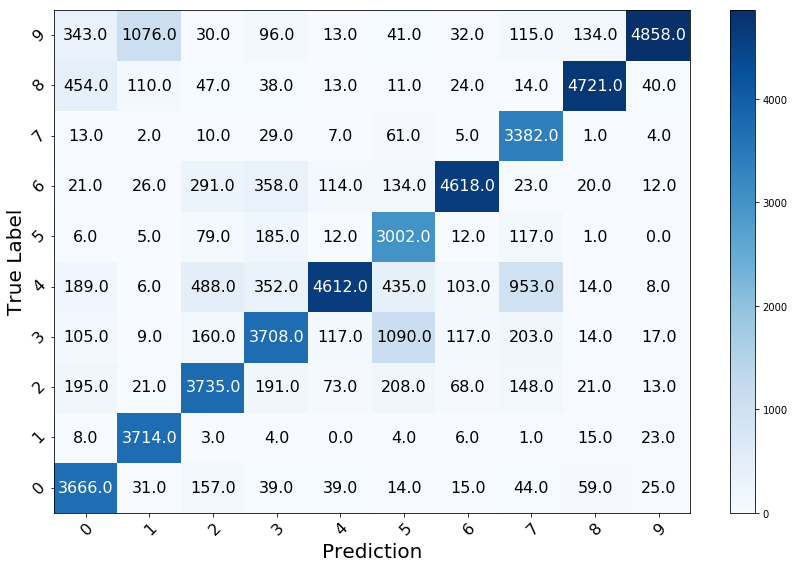

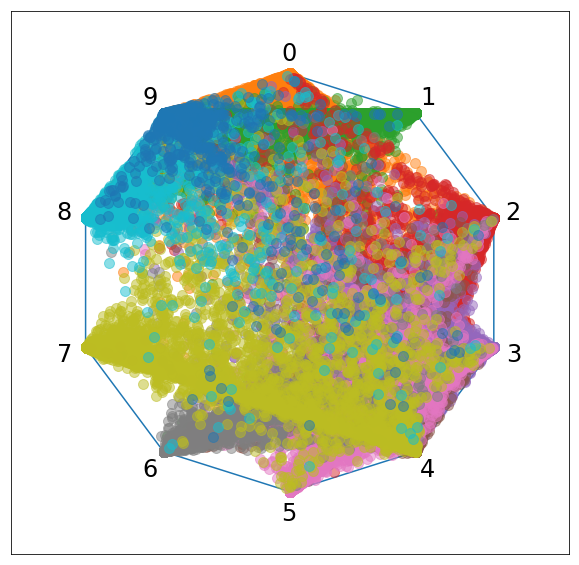

Test set accuracy mean 0.7512000000000001 std 0.06998971352991809


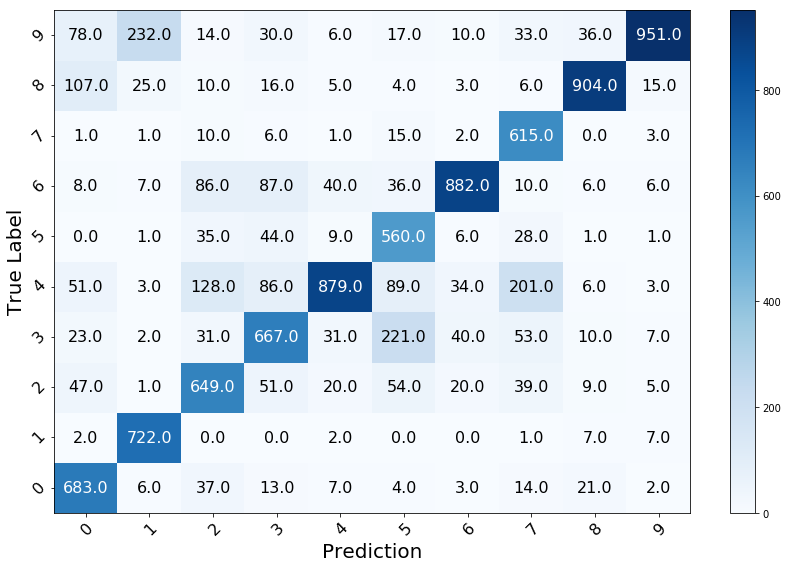

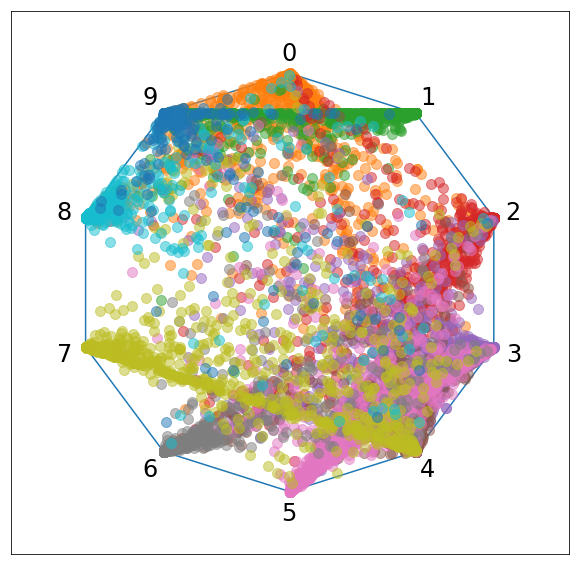

In [7]:
# For plotting a confusion matrix
from kworkshop.utils import inference_loop, plot_confusion_matrix, plot_softmax, restore_state

# Re-load the state if the weight_file is provided
if hasattr(blob,'weight_file') and blob.weight_file:
    restore_state(blob)

# For the Train set
accuracy, label, prediction, softmax = inference_loop(blob,train_loader,True)
print("Train set accuracy mean",accuracy.mean(),"std",accuracy.std())
plot_confusion_matrix(label,prediction,[str(d) for d in range(10)])
plot_softmax(label,softmax)

# For the Test set
accuracy, label, prediction, softmax = inference_loop(blob,test_loader,False)
print("Test set accuracy mean",accuracy.mean(),"std",accuracy.std())
plot_confusion_matrix(label,prediction,[str(d) for d in range(10)])
plot_softmax(label,softmax)